In [ ]:
import pandas as pd
import requests
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os.path as path
import numpy as np
import random as rd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import L2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
from tensorflow.keras.applications import ResNet50V2
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array, array_to_img

In [ ]:
import tensorflow as tf
tf.__version__

'2.17.1'

# Prepare dataset
Dataset can be found at [kaggle](https://www.kaggle.com/datasets/datamunge/sign-language-mnist) \
Because files do not persist between sessions, I have to download from Google Drive \

In [ ]:
# perform downloading datasets each session
def download_file_from_google_drive(id, destination):
  URL = "https://docs.google.com/uc?export=download"

  session = requests.Session()

  response = session.get(URL, params = { 'id' : id }, stream = True)
  token = get_confirm_token(response)

  if token:
    params = { 'id' : id, 'confirm' : token }
    response = session.get(URL, params = params, stream = True)

  save_response_content(response, destination)

def get_confirm_token(response):
  for key, value in response.cookies.items():
    if key.startswith('download_warning'):
      return value

  return None

def save_response_content(response, destination):
  CHUNK_SIZE = 32768

  with open(destination, "wb") as f:
    for chunk in response.iter_content(CHUNK_SIZE):
      if chunk: # filter out keep-alive new chunks
        f.write(chunk)


if not path.exists("sign_mnist_train.csv"):
  train_csv_id = "15yEkH1L6N0f8ijo6V3IY3QMxuv3Xmiz-"
  download_file_from_google_drive(train_csv_id, "./sign_mnist_train.csv")
if not path.exists("sign_mnist_test.csv"):
  test_csv_id = "1EcMiEgPi7cL1UTha6MEQY_RPUrxIsahh"
  download_file_from_google_drive(test_csv_id, "./sign_mnist_test.csv")

Hyperparameters

In [ ]:
VALIDATION_RATIO = 0.2
BATCH_SIZE = 128
EPOCHS = 200
NUM_CLASSES = 26
DROPOUT_RATE = 0.4

Prepare data

In [ ]:
TRAIN_DATA_PATH = "sign_mnist_train.csv"
TEST_DATA_PATH = "sign_mnist_test.csv"

train_data = pd.read_csv(TRAIN_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)

label_train = train_data["label"]
X_train = train_data.drop("label", axis=1)
X_train = np.array(X_train).reshape(-1, 28, 28, 1)
y_train = keras.utils.to_categorical(label_train, NUM_CLASSES)

image_gen = ImageDataGenerator(
  rescale=1./255, #easier for network to interpret numbers in range [0,1]
  zoom_range=0.1,
  width_shift_range=0.1,
  height_shift_range=0.1,
  rotation_range=10,
  validation_split=VALIDATION_RATIO
)

train_generator = image_gen.flow(
  X_train,
  y_train,
  batch_size=BATCH_SIZE,
  shuffle=True,
  subset='training',
  seed=42
)

valid_generator = image_gen.flow(
  X_train,
  y_train,
  batch_size=BATCH_SIZE,
  shuffle=True,
  subset='validation',
)

label_test = test_data["label"]
X_test = test_data.drop("label", axis=1)

X_test = np.array(X_test).reshape(-1, 28, 28, 1)
X_test = X_test / 255
y_test = keras.utils.to_categorical(label_test, NUM_CLASSES)

### Plot several samples

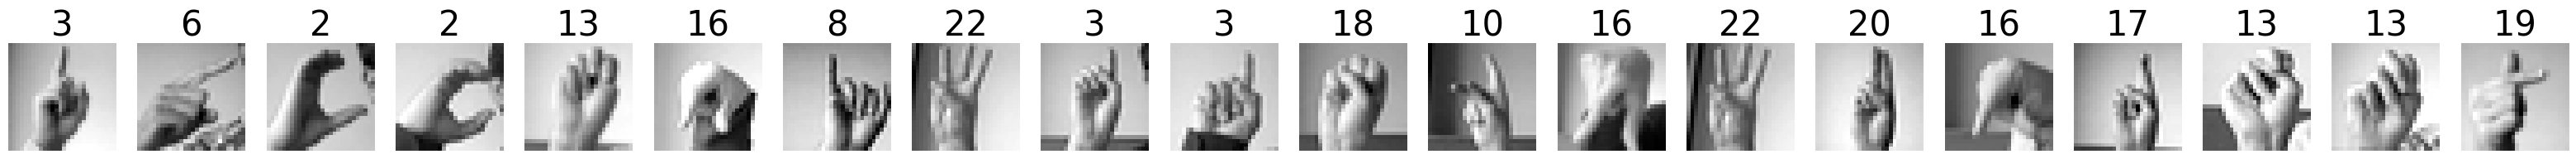

In [ ]:
# plot data
plt.figure(figsize=(40,40))

num_images = 20
for i in range(num_images):
  row = X_train[i]
  label = label_train[i]

  plt.subplot(1, num_images, i+1)
  plt.title(f"{label}", fontdict={'fontsize': 30})
  plt.axis('off')
  plt.imshow(row, cmap='gray')

# Data normalization

# Model Configuration

In [ ]:
cnn_model = keras.Sequential([
    layers.Conv2D(6, (5, 5), padding='same', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.ReLU(),
    layers.Conv2D(16, (5, 5), padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.ReLU(),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=L2()),
    layers.Dense(64, activation='relu', kernel_regularizer=L2()),
    layers.Dropout(0.2),
    layers.Dense(26, activation='softmax')
])

cnn_model.summary()

NameError: name 'keras' is not defined

In [ ]:
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cnn_model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_generator,
    callbacks=[EarlyStopping(patience=5, monitor='loss')]
  )
loss, acc = cnn_model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {acc}")
cnn_model.save("cnn_model.keras")

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.0616 - loss: 4.5665 - val_accuracy: 0.2848 - val_loss: 2.5561
Epoch 2/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.3013 - loss: 2.3920 - val_accuracy: 0.4930 - val_loss: 1.7906
Epoch 3/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.4659 - loss: 1.8413 - val_accuracy: 0.5862 - val_loss: 1.5047
Epoch 4/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.5576 - loss: 1.5731 - val_accuracy: 0.6498 - val_loss: 1.3354
Epoch 5/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.6099 - loss: 1.4285 - val_accuracy: 0.6864 - val_loss: 1.2420
Epoch 6/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.6560 - loss: 1.2941 - val_accuracy: 0.6990 - val_loss: 1.1401
Epoch 7/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.6949 - loss: 1.1887 - val_accuracy: 0.7591 - val_loss: 1.0495
Epoch 8/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.7191 - loss: 1.1380 - val_

# CNN Architecture for MNIST
https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist

In [ ]:
cnn2 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (5, 5), strides=2, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(DROPOUT_RATE),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (5, 5), strides=2, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(DROPOUT_RATE),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(DROPOUT_RATE),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

cnn2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cnn2.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=valid_generator,
    callbacks=[EarlyStopping(patience=5, monitor='loss')]
  )
loss, acc = cnn2.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {acc}")
cnn2.save("cnn2_model.keras")

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


172/172 ━━━━━━━━━━━━━━━━━━━━ 32s 112ms/step - accuracy: 0.2289 - loss: 2.9864 - val_accuracy: 0.0466 - val_loss: 6.0947
Epoch 2/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.6873 - loss: 0.9533 - val_accuracy: 0.0758 - val_loss: 5.1008
Epoch 3/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.8393 - loss: 0.4912 - val_accuracy: 0.2089 - val_loss: 3.8776
Epoch 4/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.9099 - loss: 0.2893 - val_accuracy: 0.9525 - val_loss: 0.1528
Epoch 5/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.9442 - loss: 0.1811 - val_accuracy: 0.9208 - val_loss: 0.2282
Epoch 6/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.9660 - loss: 0.1208 - val_accuracy: 0.9740 - val_loss: 0.0761
Epoch 7/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.9735 - loss: 0.0944 - val_accuracy: 0.9842 - val_loss: 0.0586
Epoch 8/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.9790 - loss: 0.0736 - val

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


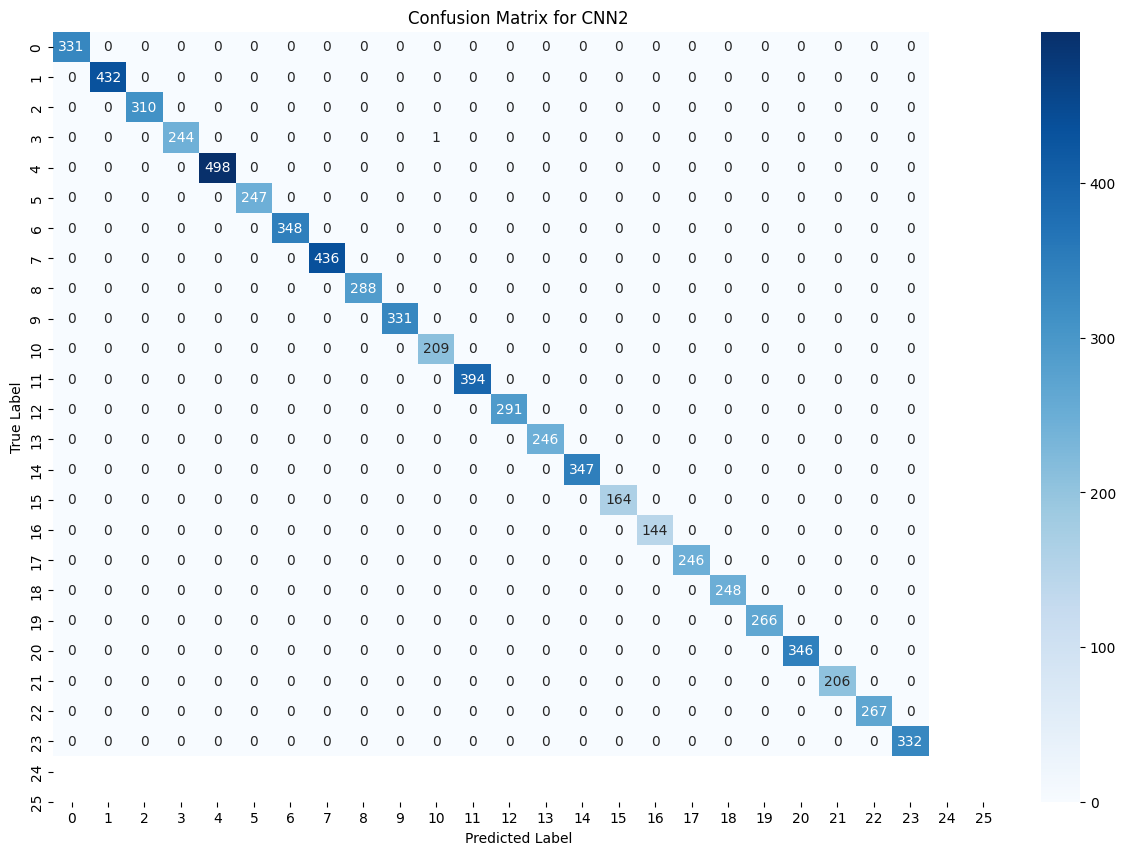

In [ ]:
# prompt: confusion matrix for test data using cnn2 to predict

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the labels for the test data using the cnn2 model
y_pred = cnn2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for CNN2')
plt.show()